In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# AI Governance with Dataplex Demo Series: Cataloging a Model Card

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.sandbox.google.com/drive/1zRYLNJp8oR4xpcMP673Lujtx3mEAhmEf#scrollTo=JAPoU8Sm5E6e">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fvertex-ai-samples%2Fmain%2Fnotebooks%2Fofficial%2Fcustom%2FSDK_Custom_Container_Predi">
      <img width="32px" src="https://cloud.google.com/ml-engine/images/colab-enterprise-logo-32px.png" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/custom/SDK_Custom_Container_Pre">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/mansim07/dataplex-ai-governance-demo/blob/main/notebooks/Cataoging_ModelCard_Using_Dataplex.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

## Overview

In this demo, we'll demonstrate how to catalog a sample Model Card using [Model Card Toolkit](https://research.google/blog/introducing-the-model-card-toolkit-for-easier-model-transparency-reporting/) in Dataplex alongside its corresponding technical model entry. Model cards are crucial for responsible AI practices. Cataloging them within Dataplex offers several key advantages:

* **Enriched Metadata**:Improve model discoverability and understanding
* **Built-in Trust**: Document model lineage, evaluation metrics, and intended use
*  **Comprehensive Documentation**: Centralize model-related information
*  **Enhanced Search**: Easily find models based on keywords and attributes

By the end of this demo, you'll understand how to leverage Dataplex to effectively manage and document your machine learning models, fostering transparency and trust.

Learn more about [Model Cards](https://modelcards.withgoogle.com/about), [Model Card Toolkit](https://research.google/blog/introducing-the-model-card-toolkit-for-easier-model-transparency-reporting/),[Cloud Dataplex](https://cloud.google.com/dataplex?e=48754805&hl=en).

## Objective

This notebook demonstrates how to generate a Model Card in HTML format using the MCT Toolkit and integrate it into Dataplex Catalog. We will extend this existing [sample code](https://github.com/tensorflow/model-card-toolkit/blob/main/model_card_toolkit/documentation/examples/Standalone_Model_Card_Toolkit_Demo.ipynb) to include Dataplex modules for cataloging the generated model card.

The steps performed include:
1. Executing an existing example from the MCT library to generate model card
2. Export the model card in HTML format using a custom jinja template
3. Create a custom technical entry in Dataplex catalog
4. Push the model card into the Entry Overview (free-style):
5. [In Future] Create a set of Model card aspects and push the model details into individual aspects:

We are using a Keras model in this demo. But the logic below also applies to any ML frameworks in general.

## Setup

### Upgrade pip and install mct, tensorflow and google cloud dataplex libraries

In [ ]:
!pip install --upgrade pip
!pip install 'model-card-toolkit' --use-deprecated=legacy-resolver
!pip install 'tensorflow'
!pip install 'tensorflow-datasets'
!pip install google-cloud-dataplex

### Restart runtime(Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab

In [ ]:
import sys

if "google.colab" in sys.modules:

    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Imports

In [ ]:
import tensorflow as tf
import numpy as np
import model_card_toolkit as mct
from model_card_toolkit.documentation.examples import cats_vs_dogs
from model_card_toolkit.utils.graphics import figure_to_base64str
import tempfile
import matplotlib.pyplot as plt
from IPython import display
import requests
import os
import zipfile

#Demo uses the latest Dataplex APIs
from google.cloud import dataplex_v1

from requests import get
from socket import gethostname, gethostbyname



## Model

We will use a pretrained model with architecture based off [MobileNetV2](https://arxiv.org/abs/1801.04381), a popular 16-layer image classification model. Our model has been trained to distinguish between betweens cats and dogs using the [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) dataset. The model training was based on the [TensorFlow transfer learning tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning).

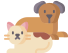

In [ ]:
URL = 'https://storage.googleapis.com/cats_vs_dogs_model/cats_vs_dogs_model.zip'
BASE_PATH = tempfile.mkdtemp()
ZIP_PATH = os.path.join(BASE_PATH, 'cats_vs_dogs_model.zip')
MODEL_PATH = os.path.join(BASE_PATH,'cats_vs_dogs_model')

r = requests.get(URL, allow_redirects=True)
open(ZIP_PATH, 'wb').write(r.content)

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(BASE_PATH)

model = tf.keras.models.load_model(MODEL_PATH)

### Dataset

In the cats-vs-dogs dataset, label=0 corresponds to cats while label=1 corresponds to dogs

#### Download Data from Tensorflow Datasets library

In [ ]:
# Download Data
import tensorflow_datasets as tfds
ds_preview, info = tfds.load('cats_vs_dogs', split='train', with_info=True)

#### View Sample Data

In [ ]:
# View Sample data
ds_example_viz=tfds.visualization.show_examples(ds_preview.take(5), info)
ds_example_viz.set_size_inches(2.5, 2.5, forward=True)
ds_example_fig = figure_to_base64str(ds_example_viz)


### Train Model and Calculate Accuracy

In [ ]:
def compute_accuracy(data):
  x = np.stack(data['examples'])
  y = np.asarray(data['labels'])
  _, metric = model.evaluate(x, y)
  return metric

In [ ]:
examples = cats_vs_dogs.get_data()
print('num validation examples:', len(examples['combined']['examples']))
print('num cat examples:', len(examples['cat']['examples']))
print('num dog examples:', len(examples['dog']['examples']))

In [ ]:
accuracy = compute_accuracy(examples['combined'])
cat_accuracy = compute_accuracy(examples['cat'])
dog_accuracy = compute_accuracy(examples['dog'])

# Use the Model Card Toolkit



## Initialize the Model Card Toolkit

In [ ]:
# https://github.com/tensorflow/model-card-toolkit/blob/master/model_card_toolkit/model_card_toolkit.py
model_card_dir = tempfile.mkdtemp()
toolkit = mct.ModelCardToolkit(model_card_dir)

# https://github.com/tensorflow/model-card-toolkit/blob/master/model_card_toolkit/model_card.py
model_card = toolkit.scaffold_assets()


## Annotate the model card

In [ ]:
 # Capture current environment details

ip = gethostbyname(gethostname()) # 172.28.0.12
fileId = get(f"http://{ip}:9000/api/sessions").json()[0]["path"].split("=")[1]
current_notebook_path="https://colab.research.google.com/drive/"+fileId+"?usp=sharing"

# Model Details
model_card.model_details.name = ''#'cat_vs_dog_model'
model_card.model_details.overview = (
    'This model distinguishes cat and dog images. It uses the MobileNetV2 '
    'architecture(https://arxiv.org/abs/1801.04381) and is trained on the '
    'Cats vs Dogs dataset available in tensor flow dataset. This model performed with high accuracy on both Cat and Dog images.'
)
model_card.model_details.documentation =('https://github.com/tensorflow/model-card-toolkit/blob/master/model_card_toolkit/documentation/examples/Standalone_Model_Card_Toolkit_Demo.ipynb')

model_card.model_details.owners = [
  mct.Owner(name='Model Cards Team', contact='model-cards@google.com')
]
model_card.model_details.version = mct.Version(name='v1.0', date='08/28/2020')
model_card.model_details.references = [
    mct.Reference(reference='https://www.tensorflow.org/guide/keras/transfer_learning'),
    mct.Reference(reference='https://arxiv.org/abs/1801.04381'),
]
model_card.model_details.licenses = [mct.License(identifier='Apache-2.0')]
model_card.model_details.citations = [mct.Citation(citation='https://github.com/tensorflow/model-card-toolkit/blob/master/model_card_toolkit/documentation/examples/Standalone_Model_Card_Toolkit_Demo.ipynb')]
model_card.model_details.path = ('https://github.com/tensorflow/model-card-toolkit/blob/master/model_card_toolkit/documentation/examples/Standalone_Model_Card_Toolkit_Demo.ipynb')

# Considerations
model_card.considerations.use_cases = [
    mct.UseCase(description='This model classifies images of cats and dogs.')
]
model_card.considerations.limitations = [
    mct.Limitation(description='This model is not able to classify images of other classes.')
]
model_card.considerations.ethical_considerations = [mct.Risk(
    name=
        'While distinguishing between cats and dogs is generally agreed to be '
        'a benign application of machine learning, harmful results can occur '
        'when the model attempts to classify images that don’t contain cats or '
        'dogs.',
    mitigation_strategy=
        'Avoid application on non-dog and non-cat images.'
)]

# Validation Set Size Bar Chart

fig, ax = plt.subplots(figsize=(1, 1))
width = 0.4
rects0 = ax.bar(0, len(examples['combined']['examples']), width, label='Overall')
rects1 = ax.bar(1, len(examples['cat']['examples']), width, label='Cat')
rects2 = ax.bar(2, len(examples['dog']['examples']), width, label='Dog')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Overall', 'Cat', 'Dog'] ,fontdict={'fontsize': 8})
ax.set_ylabel('Validation Set Size',fontdict={'fontsize': 6})
ax.set_xlabel('Slices',fontdict={'fontsize': 6})
#ax.set_title('Validation Set Size for Slices',fontdict={'fontsize': 8})

validation_set_size_barchart = figure_to_base64str(fig)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Cats', 'Dogs'
sizes = [len(examples['cat']['examples']), len(examples['dog']['examples'])]

fig1, ax1 = plt.subplots(figsize=(1, 1))
ax1.pie(sizes, labels=labels, autopct='%2.0f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


cat_vs_dog_piechart = figure_to_base64str(fig1)

# Acuracy Bar Chart

fig, ax = plt.subplots(figsize=(1, 1))
width = 0.4
rects0 = ax.bar(0, accuracy, width, label='Overall')
rects1 = ax.bar(1, cat_accuracy, width, label='Cat')
rects2 = ax.bar(2, dog_accuracy, width, label='Dog')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Overall', 'Cat', 'Dog'] , fontdict={'fontsize': 6})
ax.set_ylabel('Accuracy',fontdict={'fontsize': 6})
ax.set_xlabel('Slices',fontdict={'fontsize': 6})
#ax.set_title('Accuracy on Slices',fontdict={'fontsize': 8})
accuracy_barchart = figure_to_base64str(fig)

model_card.model_parameters.data.clear()

model_card.model_parameters.data.append(
    mct.Dataset(
        name="Cats vs Dogs Dataset",
        link="https://paperswithcode.com/dataset/cats-vs-dogs",
        graphics=mct.GraphicsCollection(
            description='Samples in the Dataset',
            collection=[
                mct.Graphic(name='Dataset Examples:', image=ds_example_fig),
                mct.Graphic(name='Validation Set Size',image=validation_set_size_barchart),
                mct.Graphic(name='Cat vs Dog distribution',image=cat_vs_dog_piechart),
                mct.Graphic(name='Accuracy',image=accuracy_barchart),

            ]
        )
    )
)

# Quantitative Analysis

model_card.quantitative_analysis.performance_metrics = [
  mct.PerformanceMetric(type='accuracy', value=str(accuracy)),
  mct.PerformanceMetric(type='accuracy', value=str(cat_accuracy), slice='cat'),
  mct.PerformanceMetric(type='accuracy', value=str(dog_accuracy), slice='Dog'),
]

model_card.quantitative_analysis.graphics.collection = [
  mct.Graphic(name='Accuracy', image=accuracy_barchart),
]



## Update the model card

In [ ]:
toolkit.update_model_card(model_card)

## Download custom html template for Dataplex



In [ ]:
!wget https://raw.githubusercontent.com/mansim07/dataplex-ai-governance-demo/main/resources/mct_templates/dataplex_mct_template.html.jinja

## Generate HTML-based model card for Dataplex

In [ ]:
my_custom_template_path = "dataplex_mct_template.html.jinja"
html_doc=toolkit.export_format(template_path=my_custom_template_path, output_file='model_card.html')  # generate the final Model Card
display.display(display.HTML(html_doc))

# Catalog Model card in Dataplex

### Authenticate your notebook environment(Colab only)
Authenticate your environment on Google Colab

In [ ]:
import sys

if "google.colab" in sys.modules:

    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information
Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
PROJECT_ID = "dataplex-shared-project-1"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

#dataplex-shared-project-1

### Set Dataplex resources

For this demo, we will create a custom entry in Dataplex Catalog for the model and then catalog the model card generated before here and push it to the overview section.

Provide a unique name for ENTRY_GROUP_ID and ENTRY_GROUP. If you want to use a pre-existing one than you can skip executing the following 2 cells.

In [ ]:
ENTRY_GROUP_ID = "ai-model"  # @param {type:"string"}
ENTRY_TYPE_ID= "custom-ai-model-test"  # @param {type:"string"}
ENTRY_ID = "cats-vs-dogs-model-test"  # @param {type:"string"}

## Create an Custom Entry. Skip this section(all 3 cells below) if you are using an existing entry

### Create an Custom Entry Group
You can skip this step if an Entry Group already exists and being re-used

In [ ]:
from google.cloud import dataplex_v1


client = dataplex_v1.CatalogServiceAsyncClient()

# Initialize request argument(s)
request_ceg = dataplex_v1.CreateEntryGroupRequest(
parent="projects/" + PROJECT_ID+ "/locations/" + LOCATION,
entry_group_id=ENTRY_GROUP_ID,
)

# Make the request

operation_ceg = client.create_entry_group(request=request_ceg)
print("Waiting for operation to complete...")
response=""

try:
  response = (await operation_ceg).result()
except Exception as e:
  if "already exists" in str(e):
    print("Entry Group already exists.")
  else:
    print("Encountered an error:", e)
# Handle the response
print(response)



### Create an Custom Entry Type

You can skip this step if an Entry Type already exists and being re-used

In [ ]:
from google.cloud import dataplex_v1


client = dataplex_v1.CatalogServiceAsyncClient()

    # Initialize request argument(s)
request_cet = dataplex_v1.CreateEntryTypeRequest(
        parent="projects/" + PROJECT_ID + "/locations/" + LOCATION,
        entry_type_id=ENTRY_TYPE_ID,
    )

    # Make the request
operation = client.create_entry_type(request=request_cet)

print("Waiting for operation to complete...")

response=""

try:
  response = (await operation).result()
except Exception as e:
  if "already exists" in str(e):
    print("Entry Group already exists.")
  else:
    print("Encountered an error:", e)
print(response)


### Create an Entry Using Dataplex API

You an skip this step if an entry already exists

In [ ]:
# Create a client
client = dataplex_v1.CatalogServiceAsyncClient()

# Initialize request argument(s)
entry = dataplex_v1.Entry()
entry.entry_type ="projects/" + PROJECT_ID + "/locations/" + LOCATION + "/entryTypes/" + ENTRY_TYPE_ID
entry_source=dataplex_v1.EntrySource()
entry_source.system="COLAB NOTEBOOKS"
entry_source.platform="Local"
entry_source.display_name=model_card.model_details.name

entry_source.description="This custom catalog entry represents a custom ai model used for Model Card Demo. [Colab Notebooks](" + current_notebook_path+ ")"

#entry.fully_qualified_name="colab_notebooks:model:dataplex-shared-project-1.us-central1.642722820551333128.1"
entry.entry_source=entry_source

request = dataplex_v1.CreateEntryRequest(
        parent= "projects/" + PROJECT_ID+ "/locations/" + LOCATION +"/entryGroups/" + ENTRY_GROUP_ID,
        entry_id=ENTRY_ID,
        entry=entry,
)

response=""
try:
  # Make the request
  response = await client.create_entry(request=request)
except Exception as e:
  if "already exists" in str(e):
    print("Entry  already exists.")
  else:
    print("Encountered an error:", e)
# Handle the response
print(response)

## Open Cloud Console to view the Entry

In [ ]:
ui_link= "https://console.cloud.google.com//dataplex/dp-entries/projects/" + PROJECT_ID + "/locations/" + LOCATION + "/entryGroups/" + ENTRY_GROUP_ID + "/entries/" + ENTRY_ID

print("click on the below link to open it in UI")
print(ui_link)



## Push the Model Card to an  Business Overview Aspect

In [ ]:
# Attach aspect to an entry

# prompt: code to attach aspect to an entry dataplex
from google.protobuf import field_mask_pb2
from google.protobuf import json_format


# Create a client
client = dataplex_v1.CatalogServiceAsyncClient()

# Initialize request argument(s)
aspect = dataplex_v1.Aspect()
aspect.aspect_type = "projects/dataplex-types/locations/global/aspectTypes/overview"

overview_data = {
    "content": html_doc,  # Model Card HTML Card
    # Add other fields as needed
}

aspect_map = {}
key_direct = f"dataplex-types.global.overview"
aspect.data=overview_data

aspect_map[key_direct] =  aspect

request = dataplex_v1.UpdateEntryRequest(
    entry=dataplex_v1.Entry(
        name= "projects/" + PROJECT_ID + "/locations/" + LOCATION + "/entryGroups/" + ENTRY_GROUP_ID + "/entries/" + ENTRY_ID,
        aspects=aspect_map
    ),
    update_mask=field_mask_pb2.FieldMask(
        paths=["aspects"]
    ),
)

# Make the request
response = await client.update_entry(request=request)

# Handle the response
print(response)


## Open Cloud Console to re-view the Entry

In [ ]:
ui_link= "https://console.cloud.google.com//dataplex/dp-entries/projects/" + PROJECT_ID + "/locations/" + LOCATION + "/entryGroups/" + ENTRY_GROUP_ID + "/entries/" + ENTRY_ID

print("click on the below link to open it in UI")
print(ui_link)